# 03-measure-novelty-from-topic-modelling

Take a matrix of documents and calculate KL between every article of a week against every article of the following week (so say, 7 articles x 5 articles = 35 article-to-article KL divergences) and then take the mean and variance of this KL divergence.

In [6]:
import numpy as np
import pandas as pd
from itertools import *

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = [7,8]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 17
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10

sns.set_context('talk')

from pprint import pprint

import imp

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

In [ ]:
n_topics=30

words_per_topic     = pd.read_csv('data/topic_word_distributions_'+str(n_topics)+'topics.csv', index_col=0)
topics_per_document = pd.read_csv('data/document_topic_distributions_'+str(n_topics)+'topics.csv', index_col=0)

#words_per_topic     = pd.read_csv('data/olddata/topic_word_distributions_'+str(n_topics)+'topics.csv', index_col=0)
#topics_per_document = pd.read_csv('data/olddata/document_topic_distributions_'+str(n_topics)+'topics.csv', index_col=0)

In [ ]:
years = range(1947,2017)

infiles = [ 'data/%d.csv' % d for d in years ]

# create DataFrame for all articles
df_alldocs = pd.DataFrame()

for infile in infiles:

    df_year = pd.read_csv(infile, index_col=0)
    df_year = df_year[pd.notnull(df_year['text'])]
    del df_year['text']
    
    # uncomment for short run
    #df = df.head(50)
    
    df_alldocs = df_alldocs.append(df_year)

In [ ]:
topics_per_document.head()

In [204]:
def corrected_entropy(v, filler=1e-5):
    minv = min(v)
    v2 = [ i if i > minv else filler for i in v ]
    return entropy(v2)*entropy_fix

In [205]:
table = topics_per_document

all_entropies = []
n_issues = []

for index, row in table.iterrows():
    topic_array = np.array(row.values,dtype=np.float64)
    all_entropies += [ corrected_entropy(topic_array) ]
    n_issues      += [ sum(row.values>0) ]

all_entropies = np.array(all_entropies)
n_issues      = np.array(n_issues)

### The effective number of topics doesn't work that well:

In [169]:
words_per_topic.loc['Topic 37'].sort_values(ascending=False).head(15)

soldaten                 0.032222
krieg                    0.019483
armee                    0.019339
general                  0.017043
bundeswehr               0.013778
waffen                   0.011480
000                      0.009754
truppen                  0.009114
offiziere                0.008104
militärs                 0.008061
militärischen            0.006773
einsatz                  0.006610
verteidigungsminister    0.005816
oberst                   0.005808
truppe                   0.005617
Name: Topic 37, dtype: float64

In [34]:
words_per_topic.loc['Topic 45'].sort_values(ascending=False).head(15)

präsident         0.028478
washington        0.020671
präsidenten       0.019906
usa               0.017178
amerikanischen    0.016662
amerikaner        0.013631
bush              0.012602
amerika           0.012505
kennedy           0.010956
reagan            0.010537
haus              0.010427
amerikas          0.010293
amerikanische     0.010027
weißen            0.009648
george            0.009404
Name: Topic 45, dtype: float64

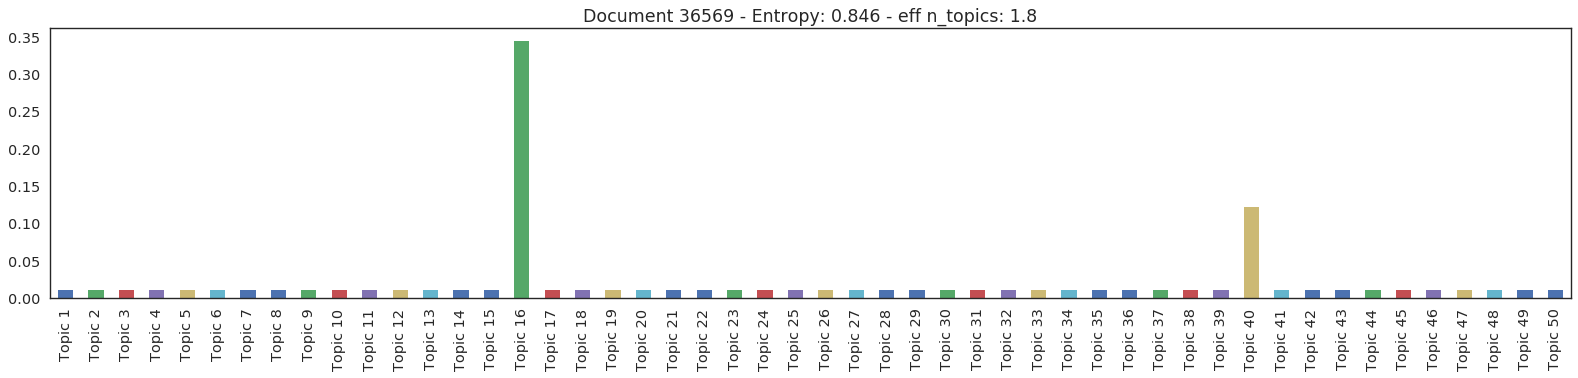

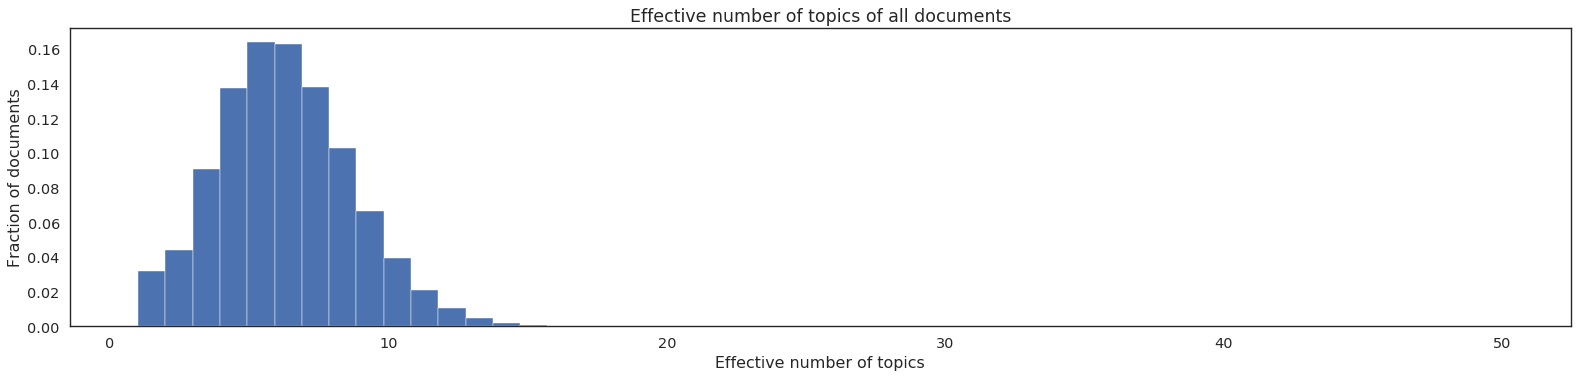

In [220]:
idx = 36569
#idx = np.random.randint(len(topics_per_document))

s = round( corrected_entropy(topics_per_document.iloc[idx]), 3 )

topics_per_document.iloc[idx].plot(kind='bar', figsize=(20,5))
plt.title("Document "+str(idx)+" - Entropy: "+str(round(s,3))+" - eff n_topics: "+str(round(2**s,2)));
plt.tight_layout()
plt.savefig('images/topic-modelling-example.png')


plt.figure(figsize=(20,5))
plt.hist(2**all_entropies, bins=50, normed=True, edgecolor='w');
plt.ylabel('Fraction of documents')
plt.xlabel('Effective number of topics')
plt.title("Effective number of topics of all documents");
plt.tight_layout()
#plt.savefig('images/eff_n_topics.png')

In [217]:
doc_to_date = { row.filename:(row.year, row.week) for _, row in df_alldocs.iterrows() }
all_dates = set(sorted(doc_to_date.values()))
all_documents = topics_per_document.index.values

from datetime import datetime
import time

dates = [ datetime.fromtimestamp(time.mktime(time.strptime('{} {} 1'.format(date[0],date[1]), '%Y %W %w'))) 
         for date in sorted(all_dates)]

In [ ]:
doc_to_entropy = { doc:s for doc,s in zip(all_documents, all_entropies) }
date_to_entropies = [ [ doc_to_entropy[doc] for doc in doc_to_date if doc_to_date[doc] == date ] \
                      for date in all_dates ]

doc_to_n_issues   = { doc:n for doc,n in zip(all_documents, n_issues) }
date_to_n_issue   = [ [ doc_to_n_issues[doc] for doc in doc_to_date if doc_to_date[doc] == date ] \
                      for date in all_dates ]

In [247]:
# save dictionaries above

outfile = 'data/dates.txt'
with open(outfile,'w') as f:
    f.write('\n'.join([str(i) for i in dates])+'\n')

outfile = 'data/date_to_entropies.csv'
with open(outfile,'w') as f:
    for j in date_to_entropies:
        f.write(','.join([str(i) for i in j])+'\n')

outfile = 'data/date_to_n_issue.csv'
with open(outfile,'w') as f:
    for j in date_to_n_issue:
        f.write(','.join([str(i) for i in j])+'\n')

In [38]:
# Novelty measures

from numpy.linalg import norm
from scipy.stats import entropy
from scipy.spatial.distance import hamming
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score

def rel_entr(P, Q):                
    return entropy(P,Q)*entropy_fix

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (rel_entr(_P, _M) + rel_entr(_Q, _M))

def BCD(P,Q):
    _P = np.array(P / norm(P, ord=1),dtype=np.float32)
    _Q = np.array(Q / norm(Q, ord=1),dtype=np.float32)
    BC = np.dot(np.sqrt(_P),np.sqrt(_Q))
    return -np.log2(BC)    

def MI(_P,_Q):
    return mutual_info_score(_P,_Q)

def novelty(p,q, metric='KL'):
    
    if metric=='KL':
        return rel_entr(p,q)
    elif metric=='hamming':
        return hamming(p>0,q>0)
    elif metric=='euclidean':
        return euclidean(p,q)
    elif metric=='JSD':
        return JSD(p,q)
    elif metric=='BCD':
        return BCD(p,q)
    elif metric=='MI':
        return MI(p,q)
    else:
        return 0

In [13]:
# Calculate novelty for every article of a week against every article of the previous week
# (so say, 50 articles x 50 articles = 2500 article-to-article KL divergences)
# Later I will then take the mean and variance of this KL divergence.

df = df_alldocs

crashed = []

all_years = sorted(df.year.unique())

for year in all_years:
    novelty_weekly = []
    all_weeks = sorted(df[df.year==year].week.unique())
    
    for week in all_weeks:
        print(year, week)
        
        # Treat 1st week 1st year separately
        if (year == all_years[0]) and (week == all_weeks[0]):
            continue
        
        # Treat 1st week
        elif (year != all_years[0]) and (week == all_weeks[0]):
            filenames_this_week = df[ (df.year==year) & (df.week==week) ].filename.values  
            filenames_prev_week = df[ (df.year==year-1) & (df.week==( df[df.year==year-1].week.max() )) ].filename.values

        else:
            filenames_this_week = df[ (df.year==year) & (df.week==week) ].filename.values
            filenames_prev_week = df[ (df.year==year) & (df.week==(week-1)) ].filename.values
            
        for fi,fj in product(filenames_this_week,filenames_prev_week):
            try:
                dfi = topics_per_document.loc[fi]
                if type(dfi) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fi])
                    dfi = dfi.iloc[0]

                dfj = topics_per_document.loc[fj]
                if type(dfj) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fj])
                    dfj = dfj.iloc[0]

                KL     = novelty(dfi, dfj)
                jensen = novelty(dfi, dfj, metric='JSD')
                bhatta = novelty(dfi, dfj, metric='BCD')
                mutual = novelty(dfi, dfj, metric='MI')/novelty(dfj, dfj, metric='MI')

                # fix: 1971 - 9 - 'd-45202934' becomes 'd-43334713'
                # topics_per_document.loc['d-45202934']
                # fix it by just taking the first of .loc:
                # rather than topics_per_document.loc['d-45202934'], do

                novelty_weekly += [(week, year, fi, fj, KL, jensen, bhatta, mutual)]
                
            except TypeError:
                crashed += [ (fi, fj) ]
                print('Crashed:',fi,fj)
            
    df_novelty_weekly = pd.DataFrame(novelty_weekly, columns=['week', 'year', 'filename1', 'filename0', \
                                                              'KL', 'jensen', 'bhatta', 'mutual'])

    df_novelty_weekly.to_csv('data/df_novelty_weekly_'+str(year)+'.csv')
    print('Saving data/df_novelty_weekly_'+str(year)+'.csv')

1947 1
1947 2
1947 3
1947 4
1947 5
1947 6
1947 7
1947 8
1947 9
1947 10
1947 11
1947 12
1947 13
1947 14
1947 15
1947 16
1947 17
1947 18
1947 19
1947 20
1947 21
1947 22
1947 23
1947 24
1947 25
1947 26
1947 27
1947 28
1947 29
1947 30
1947 31
1947 32
1947 33
1947 34
1947 35
1947 36
1947 37
1947 38
1947 39
1947 40
1947 41
1947 42
1947 43
1947 44
1947 45
1947 46
1947 47
1947 48
1947 49
1947 50
1947 51
Saving data/df_novelty_weekly_1947.csv
1948 1
1948 2
1948 3
1948 4
1948 5
1948 6
1948 7
1948 8
1948 9
1948 10
1948 11
1948 12
1948 13
1948 14
1948 15
1948 16
1948 17
1948 18
1948 19
1948 20
1948 21
1948 22
1948 23
1948 24
1948 25
1948 26
1948 27
1948 28
1948 29
1948 30
1948 31
1948 32
1948 33
1948 34
1948 35
1948 36
1948 37
1948 38
1948 39
1948 40
1948 41
1948 42
1948 44
1948 45
1948 46
1948 47
1948 48
1948 49
1948 50
1948 51
1948 52
Saving data/df_novelty_weekly_1948.csv
1949 1
1949 2
1949 3
1949 4
1949 5
1949 6
1949 7
1949 8
1949 9
1949 10
1949 11
1949 12
1949 13
1949 14
1949 15
1949 16
1949 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


1958 35
1958 36
1958 37
1958 38
1958 39
1958 40
1958 41
1958 42
1958 43
1958 44
1958 45
1958 46
1958 47
1958 48
1958 49
1958 50
1958 51
1958 52
Saving data/df_novelty_weekly_1958.csv
1959 1
1959 2
1959 3
1959 4
1959 5
1959 6
1959 7
1959 8
1959 9
1959 10
1959 11
1959 12
1959 13
1959 14
1959 15
1959 16
1959 17
1959 18
1959 19
1959 20
1959 21
1959 22
1959 23
1959 24
1959 25
1959 26
1959 27
1959 28
1959 29
1959 30
1959 31
1959 32
1959 33
1959 34
1959 35
1959 36
1959 37
1959 38
1959 39
1959 40
1959 41
1959 42
1959 43
1959 44
1959 45
1959 46
1959 47
1959 48
1959 49
1959 50
1959 51
1959 52
Saving data/df_novelty_weekly_1959.csv
1960 1
1960 3
1960 4
1960 5
1960 6
1960 7
1960 8
1960 9
1960 10
1960 11
1960 12
1960 13
1960 14
1960 15
1960 16
1960 17
1960 18
1960 19
1960 20
1960 21
1960 22
1960 23
1960 24
1960 25
1960 26
1960 27
1960 28
1960 29
1960 30
1960 31
1960 32
1960 33
1960 34
1960 35
1960 36
1960 37
1960 38
1960 39
1960 40
1960 41
1960 42
1960 43
1960 44
1960 45
1960 46
1960 47
1960 48
196

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
1970 11
1970 12
1970 13
1970 14
1970 15
1970 16
1970 17
1970 18
1970 19
1970 20
1970 21
1970 22
1970 23
1970 24
1970 25
1970 26
1970 27
1970 28
1970 29
1970 30
1970 31
1970 32
1970 33
1970 34
1970 35
1970 36
1970 37
1970 38
1970 39
1970 40
1970 41
1970 42
1970 43
1970 44
1970 45
1970 46
1970 47
1970 48
1970 49
1970 50
1970 51
1970 52
1970 53
Saving data/df_novelty_weekly_1970.csv
1971 1
1971 3
1971 4
1971 5
1971 6
1971 7
1971 8
1971 9
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DI

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

1971 10
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970   

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
1975 47
1975 48
1975 49
1975 50
1975 51
1975 52
1975 53
Saving data/df_novelty_weekly_1975.csv
1976 1
1976 3
1976 4
1976 5
1976 6
1976 7
1976 8
1976 9
1976 10
1976 11
1976 12
1976 13
1976 14
1976 15
1976 16
1976 17
1976 18
1976 19
1976 20
1976 22
1976 23
1976 24
1976 25
1976 26
1976 27
1976 28
1976 29
1976 30
1976 31
1976 32
1976 33
1976 34
1976 35
1976 36
1976 37
1976 38
1976 39
1976 40
1976 41
1976 42
1976 43
1976 44
1976 45
1976 46
1976 47
1976 48
1976 49
1976 50
1976 51
1976 52
1976 53
Saving data/df_novelty_weekly_1976.csv
1977 1
1977 3
1977 4
1977 5
1977 6
1977 7
1977 8
1977 9
1977 10
1977 11
1977 12
1977 13
1977 14
19

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACH

      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-6684

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  N

      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahr

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahr

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACH

      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-6684

      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  N

      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIE

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahr

      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIE

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahr

      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIE

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

2005 29
2005 30
2005 31
2005 32
2005 33
2005 34
2005 35
2005 36
2005 37
2005 38
2005 39
2005 40
2005 41
2005 42
2005 43
2005 44
2005 45
2005 46
2005 47
2005 48
2005 49
2005 50
2005 51
2005 52
Saving data/df_novelty_weekly_2005.csv
2006 1
2006 2
2006 3
2006 4
2006 5
2006 6
2006 7
2006 8
2006 9
2006 10
2006 11
2006 12
2006 13
2006 14
2006 15
2006 16
2006 17
2006 18
2006 19
2006 20
2006 21
2006 22
2006 23
2006 24
2006 25
2006 26
2006 27
2006 28
2006 29
2006 30
2006 31
2006 32
2006 33
2006 34
2006 35
2006 36
2006 37
2006 38
2006 39
2006 40
2006 41
2006 42
2006 43
2006 44
2006 45
2006 46
2006 47
2006 48
2006 49
2006 50
2006 51
2006 52
Saving data/df_novelty_weekly_2006.csv
2007 1
2007 2
2007 3
2007 4
2007 5
2007 6
2007 7
2007 8
2007 9
2007 10
2007 11
2007 12
2007 13
2007 14
2007 15
2007 16
2007 17
2007 18
2007 19
2007 20
2007 21
2007 22
2007 23
2007 24
2007 25
2007 26
2007 27
2007 28
2007 29
2007 30
2007 31
2007 32
2007 33
2007 34
2007 35
2007 36
2007 37
2007 38
2007 39
2007 40
2007 41
2007

In [ ]:
"""
# Calculate novelty for every article of a 4-week period month against every article of the previous 4 weeks

# Exclude the previous week because we already have that

df = df_alldocs

all_years = sorted(df.year.unique())
crashed = []

for year in all_years:
    all_weeks = sorted(df[df.year==year].week.unique())

    novelty_monthly = []
    
    for week in all_weeks:
        print(year, week)
        
        # Treat 1st weeks 1st year separately
        if (year == all_years[0]) and (week < all_weeks[4]):
            continue
        
        # Treat 1st weeks
        elif (year != all_years[0]) and (week < all_weeks[4]):
            filenames_this_week  = df[ (df.year==year) & (df.week==week) ].filename.values  
            filenames_prev_month = df[ (df.year==year-1) & (df.week>(df[df.year==year-1].week.max()-4)) ].filename.values

        else:
            filenames_this_week  = df[ (df.year==year) & (df.week==week) ].filename.values
            filenames_prev_month = df[ (df.year==year) & (df.week<week) & (df.week>=(week-4)) ].filename.values
            
        for fi,fj in product(filenames_this_week,filenames_prev_month):
            try:
                dfi = topics_per_document.loc[fi]
                if type(dfi) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fi])
                    dfi = dfi.iloc[0]

                dfj = topics_per_document.loc[fj]
                if type(dfj) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fj])
                    dfj = dfj.iloc[0]

                KL     = novelty(dfi, dfj)
                jensen = novelty(dfi, dfj, metric='JSD')
                bhatta = novelty(dfi, dfj, metric='BCD')
                mutual = novelty(dfi, dfj, metric='MI')/novelty(dfj, dfj, metric='MI')

                novelty_monthly += [(week, year, fi, fj, KL, jensen, bhatta, mutual)]
            except TypeError:
                crashed += [ (fi, fj) ]
                print('Crashed:',fi,fj)
            
    df_novelty_monthly = pd.DataFrame(novelty_monthly, columns=['week', 'year', 'filename1', 'filename0', \
                                                                'KL', 'jensen', 'bhatta', 'mutual'])
    
    df_novelty_monthly.to_csv('data/df_novelty_monthly_'+str(year)+'.csv')
    print('Saving data/df_novelty_monthly_'+str(year)+'.csv')
"""    

In [316]:
# Compare all weeks from 2015 to the 10 weeks before that. Do the same for every 5 years before that

df = df_alldocs

test_years = np.arange(1950,2020,5)

for week_idx in range(10,51):
    print(week_idx)
    for year in test_years:

        filenames_this_week  = df[ (df.year==year) & (df.week==week_idx) ].filename.values
        filenames_past       = df[ (df.year==year) & (df.week<week_idx) & (df.week>=(week_idx-10)) ].filename.values
        novelty_weeks = []

        print(len(filenames_this_week)*len(filenames_past))
        for fi,fj in product(filenames_this_week,filenames_past):
            try:
                dfi = topics_per_document.loc[fi]
                if type(dfi) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fi])
                    dfi = dfi.iloc[0]

                dfj = topics_per_document.loc[fj]
                if type(dfj) == pd.core.frame.DataFrame:
                    print('Document ID clash:')
                    print(df[df.filename==fj])
                    dfj = dfj.iloc[0]

                KL     = novelty(dfi, dfj)
                jensen = novelty(dfi, dfj, metric='JSD')
                bhatta = novelty(dfi, dfj, metric='BCD')
                mutual = novelty(dfi, dfj, metric='MI')/novelty(dfj, dfj, metric='MI')

                novelty_weeks += [(week, year, fi, fj, KL, jensen, bhatta, mutual)]
                if len(novelty_weeks) % 1000 == 0:
                    print(len(novelty_weeks))

            except TypeError:
                crashed += [ (fi, fj) ]
                print('Crashed:',fi,fj)

        df_novelty_weeks = pd.DataFrame(novelty_weeks, columns=['week', 'year', 'filename1', 'filename0', \
                                                                    'KL', 'jensen', 'bhatta', 'mutual'])

        outfile = 'data/df_novelty_week%d_%d.csv' % (week_idx, year)
        df_novelty_weeks.to_csv(outfile)
        print('Saving',outfile)

10
27560
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
Saving data/df_novelty_week10_1950.csv
21208
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
Saving data/df_novelty_week10_1955.csv
28899


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


1000


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
Saving data/df_novelty_week10_1960.csv
44496
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
Saving data/df_novelty_week10_1965.csv
54199
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
1000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section       

22000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
23000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
24000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
25000
Document ID clash:
      year  week section                  headline lead    filena

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
47000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
48000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
49000
Document ID clash:
      year  week section                  headline lead    filename
263

18000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
19000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
20000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
21000
Document ID clash:
      year  week                  section

47000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
48000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
49000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
50000
Document ID clash:
      year  week                  section

75000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
76000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
77000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
78000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Saving data/df_novelty_week10_1980.csv
74765
Document ID cla

9000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
10000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984 

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
19000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
20000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-6684948

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
39000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
40000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-6684948

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
49000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  198

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
59000
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
69000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  198

147000
148000
149000
150000
151000
Saving data/df_novelty_week10_2000.csv
132792
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
Saving data/df_novelty_week10_2005.csv
34650
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
1

19000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
20000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
21000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
22000
Document ID clash:
      year  week section                  headline lead    filena

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
47000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
48000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
49000
Document ID clash:
      year  week section                  headline lead    filename
263

10000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
11000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
12000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
13000
Document ID clash:
      year  week                  section

41000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
42000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
43000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
44000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section

72000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
73000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
74000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
75000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
76000
Document ID clash:
      year  week                  s

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
9000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
20000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
21000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-6684948

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
31000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  198

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
42000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
43000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-6684948

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
53000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  198

Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
64000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
4014  1985     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-66849484
Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
65000
Document ID clash:
      year  week section                  headline lead    filename
3971  1984     1     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-6684948

Document ID clash:
      year  week            section                  headline lead    filename
3992  1984     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
4041  1985     1  Jahres-Bestseller  BELLETRISTIK, SACHBÜCHER  NaN  d-66849483
Document ID clash:
      year  week section   headline lead    filename
4024  1984     1     NaN  Impressum  NaN  d-66849482
4058  1985     1     NaN  Impressum  NaN  d-66849482
Saving data/df_novelty_week11_1985.csv
97008
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
9000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
10000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
11000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
37000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
38000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
39000
Document ID clash:
      year  week section                  headline lead    filename
263

64000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
65000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
66000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
67000
Document ID clash:
      year  week section                  headline lead    filena

24000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
25000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
26000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
27000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
28000
Document ID clash:
      year  week                  s

55000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
56000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
57000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
58000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
59000
Document ID clash:
      year  week                  s

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
87000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
88000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
89000
Saving data/df_novelty_week12_1980.csv
82156
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
4

7000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
8000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
9000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
10000
Document ID clash:
      year  week section                  headline lead    filename


Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
38000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
39000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
40000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
41000
Document ID clash:
      year  week section                  headline lead    filena

68000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
69000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
70000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
71000
Document ID clash:
      year  week section                  headline lead    filena

27000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
28000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
29000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
30000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
31000
Document ID clash:
      year  week                  s

62000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
63000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
64000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
65000
Document ID clash:
      year  week                  section

33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
Saving data/df_novelty_week13_1995.csv
185610
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
450

15000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
16000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
17000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
18000
Document ID clash:
      year  week section                  headline lead    filena

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
46000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
47000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
48000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
49000
Document ID clash:
      year  week section                  headline lead    filena

9000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
10000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
11000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
12000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
13000
Document ID clash:
      year  week                  se

44000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
45000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
46000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
47000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
48000
Document ID clash:
      year  week                  s

78000
Saving data/df_novelty_week14_1980.csv
77605
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
Saving data/df_novelty_week14_1985.csv
115808
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
770

9000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
10000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
11000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
12000
Document ID clash:
      year  week section                  headline lead    filenam

39000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
40000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
41000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
42000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
43000
Document ID clash:
      year  week section                  headline lead    

70000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
71000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
72000
Saving data/df_novelty_week15_1970.csv
51840
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
4

4000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
5000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
6000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
7000
Document ID clash:
      year  week section                  headline lead    filename
2

34000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
35000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
36000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
37000
Document ID clash:
      year  week section                  headline lead    filena

64000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
65000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
66000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
67000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
68000
Document ID clash:
      year  week section                  headline lead    

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
Saving data/df_novelty_week16_2005.csv
30581
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
240

Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
23000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
24000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
25000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
26000
Document ID clash:
      year  week section                  headline lead    filena

53000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
54000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
55000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
56000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filena

34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
18

18000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
19000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
20000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
21000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
22000
Document ID clash:
      year  week section                  headline lead    

49000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
50000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
51000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
52000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filena

94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
Saving data/df_novelty_week18_1990.csv
131979
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
Saving data/df_novelty_week18_1995.csv
174371
1000
2000
3000

14000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
15000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
16000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
17000
Document ID clash:
      year  week section                  headline lead    filena

45000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
46000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
47000
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
Document ID clash:
      year  week section                  headline lead    filename
2635  1970     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
2670  1971     9     NaN  DIESE WOCHE IM FERNSEHEN  NaN  d-45202934
48000
Document ID clash:
      year  week section                  headline lead    filena

100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
Saving data/df_novelty_week19_1995.csv
177688
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
11100

111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
Saving data/df_novelty_week20_2000.csv
136764
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
980

121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
Saving data/df_novelty_week21_2005.csv
29592
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Saving data/df_novelty_week21_2010.csv
38464
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
Saving data/df_novelty_week21_2015.csv
22
29960
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Saving data/df_novelty_week22_1950.csv
11919
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Saving data/df_novelty_week22_1955.csv
33156
1000
2000
3000
4000

12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
Saving data/df_novelty_week23_1965.csv
67071
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
Saving data/df_novelty_week23_1970.csv
54242
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
3100

34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
Saving data/df_novelty_week24_1980.csv
72675
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
Saving data/df_novelty_week24_1985.csv
99078
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
3200

80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
Saving data/df_novelty_week25_1990.csv
148215
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
1350

27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
Saving data/df_novelty_week26_2000.csv
129498
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000

69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
Saving data/df_novelty_week27_2005.csv
31304
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
Saving data/df_novelty_week27_2010.csv
34160
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
Saving data/df_novelty_week27_2015.csv
28
33728
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
Saving data/df_novelty_week29_1960.csv
70933
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
Saving data/df_novelty_week29_1965.csv
68991
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
Saving data/df_novelty

42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
Saving data/df_novelty_week30_1980.csv
69120
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
Saving data/df_novelty_week30_1985.csv
94464
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
3600

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
Saving data/df_novelty_week32_2000.csv
119626
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000


79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
Saving data/df_novelty_week33_2005.csv
68392
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
Saving data/df_novelty_week33_2010.csv
33440
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
Saving data/df

34000
35000
Saving data/df_novelty_week35_1960.csv
62775
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
Saving data/df_novelty_week35_1965.csv
52126
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
Saving data/df_novelty_week35_1970.csv
51800
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
3300

2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
Saving data/df_novelty_week36_1980.csv
73100
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
Saving data/df_novelty_week37_1990.csv
151855
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Saving data/df_novelty_week38_2000.csv
108702
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
Saving data/df_novelty_week38_2005.csv
46516
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


17000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
18000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
19000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
20000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
21000
Document ID clash:
      year  week section                   head

53000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
54000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
55000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
56000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
57000
Document ID clash:
      year  week section                   head

90000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
90

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      ye

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   19

      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  B

103000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
104000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
105000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
106000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
107000
Document ID clash:
      year  week section                  

44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
Saving data/df_novelty_week40_1965.csv
66780
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
Saving data/df_novelty_week40_1970.csv
57429
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
Saving data/df_novelty

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
14000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
15000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
33000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
34000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
51000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
52000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
70000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
71000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
88000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
89000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

106000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
107000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
108000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    file

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
12000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
13000
Document ID clash:
      year  week section                   headline lead    filen

30000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
31000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
32000
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
49000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
50000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
51000
Document ID clash:
      year  week section                   headline lead   

67000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
68000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
69000
Document ID clash:
      year  week section                   headline lead   

86000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
87000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
88000
Document ID clash:
      year  week section                   headline lead   

105000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
106000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
107000
Document ID clash:
      year  week section                   headline lead

40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
Saving data/df_novelty_week42_1975.csv
87699
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
1000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
3000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Versio

33000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
34000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
35000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
36000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
37000
Document ID clash:
      year  week                  s

66000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
67000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
68000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
69000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
70000
Document ID clash:
      year  week                  s

5000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
6000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
7000
Document ID clash:
      year  week section                   headline lead    fi

24000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
25000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
26000
Document ID clash:
      year  week section                   headline lead   

43000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
44000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
45000
Document ID clash:
      year  week section                   headline lead   

62000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
63000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
64000
Document ID clash:
      year  week section                   headline lead   

81000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
82000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
83000
Document ID clash:
      year  week section                   headline lead   

100000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
101000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
102000
Document ID clash:
      year  week section                   headline lead

59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
Saving data/df_novelty_week42_1995.csv
203031
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63

11000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
12000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
13000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
14000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
15000
Document ID clash:
      year  week                  s

44000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
45000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
46000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
47000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
48000
Document ID clash:
      year  week                  s

77000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
78000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
79000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
80000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
81000
Document ID clash:
      year  week                  s

6000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
7000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
8000
Document ID clash:
      year  week section                   headline lead    fi

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
26000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
27000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

45000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
46000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
47000
Document ID clash:
      year  week section                   headline lead   

64000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
65000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
66000
Document ID clash:
      year  week section                   headline lead   

83000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
84000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
85000
Document ID clash:
      year  week section                   headline lead   

102000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
103000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
104000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead

44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000

15000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
16000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
17000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
18000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
19000
Document ID clash:
      year  week                  s

48000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
49000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
50000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
51000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
52000
Document ID clash:
      year  week                  s

82000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
83000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
84000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
85000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section

14000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
15000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
16000
Document ID clash:
      year  week section                   headline lead   

33000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
34000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
35000
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
53000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
54000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
55000
Document ID clash:
      year  week section                   headline lead   

72000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
73000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
74000
Document ID clash:
      year  week section                   headline lead   

91000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
92000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
93000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead   

111000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
112000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
113000
Document ID clash:
      year  week section                   headline lead

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  

      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN 

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35

29000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
30000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
31000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
32000
Document ID clash:
      year  week                  section

62000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
63000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
64000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
65000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
66000
Document ID clash:
      year  week                  s

30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
Saving data/df_novelty_week45_1985.csv
119680
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
19000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
20000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
39000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
40000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
58000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
59000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
60000
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
78000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
79000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

97000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
98000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
99000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
117000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
118000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    fil

6000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
7000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
8000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
9000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
10000
Document ID clash:
      year  week section     headli

40000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
41000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
42000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
43000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
9000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
10000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
11000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
12000
Document ID clash:
      year  week                  section 

42000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
43000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
44000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
45000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
46000
Document ID clash:
      year  week                  s

76000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
77000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
78000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
79000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
8000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
9000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
10000
Document ID clash:
      year  week section                   headline lead    f

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
28000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
29000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
48000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
49000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
67000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
68000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
69000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
87000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
88000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
107000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
108000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    fil

39000
40000
41000
42000
43000
Saving data/df_novelty_week47_1960.csv
77778
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
Saving data/df_novelty_week47_1965.csv
78387
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
7300

30000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
31000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
32000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
33000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
34000
Document ID clash:
      year  week section     he

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
6000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
7000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
8000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headli

38000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
39000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
40000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
41000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
42000
Document ID clash:
      year  week                  s

72000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
73000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
74000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
75000
Document ID clash:
      year  week                  section

3000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
4000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
5000
Document ID clash:
      year  week section                   headline lead    fi

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
23000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
24000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
25000
Document ID clash:
      year  week section                   headline lead   

42000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
43000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
44000
Document ID clash:
      year  week section                   headline lead   

62000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
63000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
64000
Document ID clash:
      year  week section                   headline lead   

81000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
82000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
83000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
84000
Document ID clash:
      year  week section                   headline l

101000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
102000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
103000
Document ID clash:
      year  week section                   headline lead

177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000
203000
204000
205000
206000
207000
208000
209000
210000
211000
212000
213000
214000
215000
Saving data/df_novelty_week47_2000.csv
128707
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
11300

Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
21000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
22000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
23000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
24000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline

55000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
56000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
57000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Saving data/df_novelty_week48_1975.csv
90710
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
1000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-6

32000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
33000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
34000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
35000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
36000
Document ID clash:
      year  week                  s

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
66000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
67000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
68000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
69000
Document ID clash:
      year  week                  section

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
4000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
5000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filenam

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
24000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
25000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
43000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
44000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
45000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead   

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
63000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
64000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
83000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
84000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filen

Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
103000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
104000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
Document ID clash:
      year  week section                   headline lead    fil

87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
Saving data/df_novelty_week48_2005.csv
41602
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
Saving data/df_novelty_week48_2010.csv
39180
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
Saving data/df_novelty_week48_2015.csv
49
16650
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
Saving data

24000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
25000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
26000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
27000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
28000
Document ID clash:
      year  week section     he

59000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
60000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
61000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
62000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
63000
Saving data/df_novelty_week49_1975.csv
95900
Docum

30000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
31000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
32000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
33000
Document ID clash:
      year  week                  section

63000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
64000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
65000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
66000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
67000
Document ID clash:
      year  week                  s

30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
Saving data/df_novelty_week49_1985.csv
98917
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
2000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRIS

37000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
38000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
39000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
40000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
41000
Document ID clash:
      year  week section                   head

76000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
77000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
78000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
79000
Document ID clash:
      year  week section                   headline lead    filename
901   1990    39     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
1521  1990    38     NaN  BELLESTRISTIK, SACHBÜCHER  NaN  d-67858763
80000
Document ID clash:
      year  week section                   head

Saving data/df_novelty_week49_2010.csv
61100
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
Saving data/df_novelty_week49_2015.csv
50
18564
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
Saving data/df_novelty_week50_1950.csv
25812
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Saving data/df_novelty_week50_1955.csv
48545
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
3

26000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
27000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
28000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
29000
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
Document ID clash:
      year  week section     headline lead    filename
2080  1974    45     NaN  HOHLSPIEGEL  NaN  d-41652428
2197  1975    45     NaN  HOHLSPIEGEL  NaN  d-41652428
30000
Document ID clash:
      year  week section     he

61000
Saving data/df_novelty_week50_1975.csv
91200
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
1000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
3000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
4000
Document ID c

Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
34000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
35000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
36000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
37000
Document ID clash:
      year  week                  section

67000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
68000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
69000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
70000
Document ID clash:
      year  week                  section   headline lead    filename
2532  1980    41  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
2640  1980     4  Vorwahl-Version 41/1980  Impressum  NaN  d-62750172
71000
Document ID clash:
      year  week                  s

16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000

In [ ]:
# Compare all weeks from all years to the 10 weeks before that.

df = df_alldocs

#novelty_years = np.arange(1950,2020,5)
#novelty_years = np.arange(1947,2017)
novelty_years = [2007]

#week_range = range(10,51)
week_range = [17]

week_gap = 4

for week_idx in week_range:
    print(week_idx)
    for year in novelty_years:

        filenames_this_week  = df[ (df.year==year) & (df.week==week_idx) ].filename.values
        filenames_past       = df[ (df.year==year) & (df.week<week_idx) & (df.week>=(week_idx-week_gap)) ].filename.values
        novelty_weeks = []

        print('len(filenames_this_week)*len(filenames_past) = %d' % (len(filenames_this_week)*len(filenames_past)) )
        for fi,fj in product(filenames_this_week,filenames_past):
            try:
                dfi = topics_per_document.loc[fi]
                if type(dfi) == pd.core.frame.DataFrame:
                    #print('Document ID clash:')
                    #print(df[df.filename==fi])
                    dfi = dfi.iloc[0]

                dfj = topics_per_document.loc[fj]
                if type(dfj) == pd.core.frame.DataFrame:
                    #print('Document ID clash:')
                    #print(df[df.filename==fj])
                    dfj = dfj.iloc[0]

                KL     = novelty(dfi, dfj)
                #jensen = novelty(dfi, dfj, metric='JSD')
                #bhatta = novelty(dfi, dfj, metric='BCD')
                #mutual = novelty(dfi, dfj, metric='MI')/novelty(dfj, dfj, metric='MI')

                #novelty_weeks += [(week, year, fi, fj, KL, jensen, bhatta, mutual)]
                novelty_weeks += [(week_idx, year, fi, fj, KL)]
                if len(novelty_weeks) % 1000 == 0:
                    print(len(novelty_weeks))

            except TypeError:
                #crashed += [ (fi, fj) ]
                print('Crashed:',fi,fj)

        df_novelty_weeks = pd.DataFrame(novelty_weeks, columns=['week', 'year', 'filename1', 'filename0', 'KL'])
                                                                    #'jensen', 'bhatta', 'mutual'])

        outfile = 'data/df_novelty_week%d_%d.csv' % (week_idx, year)
        df_novelty_weeks.to_csv(outfile)
        print('Saving',outfile)

In [ ]:
df_novelty_weeks = pd.DataFrame(novelty_weeks, columns=['week', 'year', 'filename1', 'filename0', 'KL'])
df_novelty_weeks

# Check that the novelty curve is the same for all K

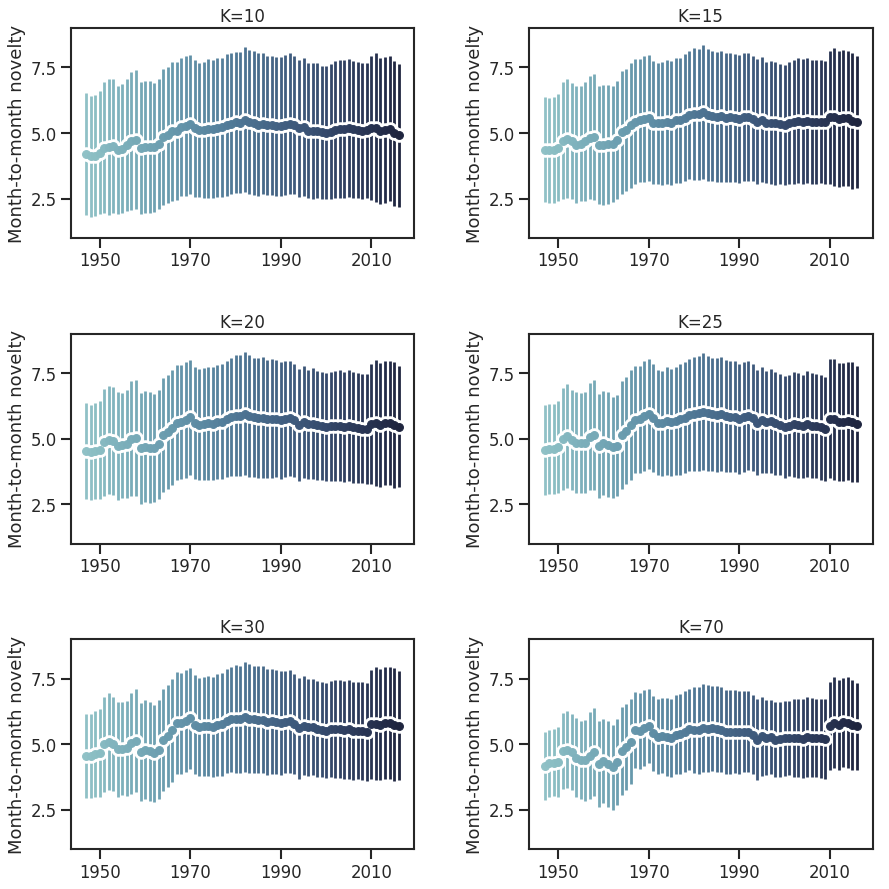

In [36]:
sns.set_context('talk', font_scale=0.9)
sns.set_style('ticks')
Ks = [10,15,20,25,30,70]
fig, axs = plt.subplots(3,2,figsize=(12,12))
axs = axs.flatten()

for ax,K in zip(axs,Ks):
    infile_years     = 'data/df_novelty_{}topics_over_years.csv'.format(K)
    df = pd.read_csv(infile_years, index_col=0)
    df.columns = ['meanKL','stdKL']

    years = df.index
    pal = sns.cubehelix_palette(len(years), rot=-.25, light=.7)
    colour_dict = { y:c for y,c in zip(years, pal) }

    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})

    x    = df.index.values
    y    = df['meanKL'].values
    yerr = df['stdKL'].values
    c = [colour_dict[i] for i in x]

    ax.plot(x,y, markersize=12, marker='o', c='w');
    for ix, iy, iyerr, ic in zip(x,y,yerr,c):
        ax.errorbar(ix,iy, yerr=iyerr, markersize=7, marker='o', c=ic);

    #ax.set_ylabel(r'Month-to-month $D_{KL}$')
    ax.set_ylabel(r'Month-to-month novelty')
    ax.set_ylim(1,9)    
    
    xticks = np.arange(1950,2030,20)
    ax.set_xticks(xticks)
    
    ax.set_title('K='+str(K),fontsize=15)

plt.tight_layout()
plt.savefig('../images-paper/novelty-over-years-Spiegel-many-K.png')
plt.show()

# We have the same data for every week, in:
# infile_yearweeks = 'data/df_novelty_{}topics_over_yearweeks.csv'.format(K)    